<a href="https://colab.research.google.com/github/Sricharangoud/EXPLAINABLE-AI/blob/main/ASSIGNMENT_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# ===== 1. Imports & Helpers =====
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

In [9]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Imbalance
from imblearn.over_sampling import SMOTE
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# PDP (updated import for sklearn >=1.2)
from sklearn.inspection import PartialDependenceDisplay
RANDOM_STATE = 42

In [11]:
# Utility: evaluation summary
def eval_summary(y_true, y_pred, y_prob=None):
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred, zero_division=0)
  rec = recall_score(y_true, y_pred, zero_division=0)
  f1 = f1_score(y_true, y_pred, zero_division=0)
  roc = roc_auc_score(y_true, y_prob) if (y_prob is not None) else None
  return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc}

In [7]:
# ===== 2. Load dataset & basic EDA =====
DATA_PATH = '/content/lung_cancer_dataset.csv'
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
print(df.head())
target = 'lung_cancer'
X = df.drop(columns=['patient_id', target])
y = df[target].map({'No':0, 'Yes':1})
#Identify categorical and numerical features
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
# Preprocessor
numeric_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
transformers=[
('num', numeric_transformer, num_cols),
('cat', categorical_transformer, cat_cols)
])
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
# Balance with SMOTE
sm = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = sm.fit_resample(pd.get_dummies(X_train, drop_first=True), y_train)
X_test_res = pd.get_dummies(X_test, drop_first=True).reindex(columns=X_train_res.columns, fill_value=0)
# Train RandomForest for feature importance
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test_res)
y_prob = rf.predict_proba(X_test_res)[:,1]
print("RF Evaluation:", eval_summary(y_test, y_pred, y_prob))
# Feature importance DataFrame
fi_df = pd.DataFrame({
'feature': X_train_res.columns,
'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

Dataset shape: (50000, 11)
   patient_id  age  gender  pack_years radon_exposure asbestos_exposure  \
0      100000   69    Male   66.025244           High                No   
1      100001   32  Female   12.780800           High                No   
2      100002   89  Female    0.408278         Medium               Yes   
3      100003   78  Female   44.065232            Low                No   
4      100004   38  Female   44.432440         Medium               Yes   

  secondhand_smoke_exposure copd_diagnosis alcohol_consumption family_history  \
0                        No            Yes            Moderate             No   
1                       Yes            Yes            Moderate            Yes   
2                       Yes            Yes                 NaN             No   
3                       Yes             No            Moderate             No   
4                        No            Yes                 NaN            Yes   

  lung_cancer  
0          No  
1  

PDP features: ['pack_years', 'age']


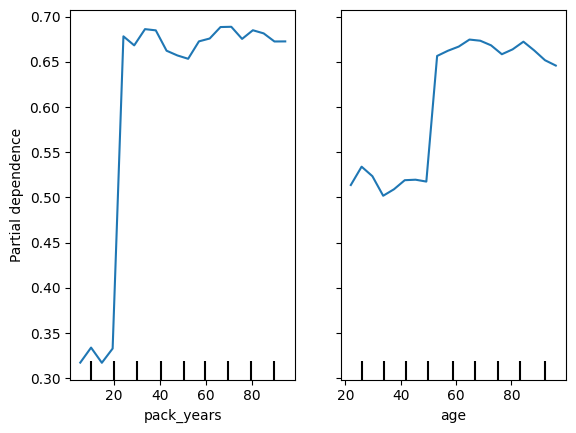

In [12]:
# ===== 6.4 PDP & ICE for top features =====
top_feats = fi_df['feature'].tolist()[:2]
print('PDP features:', top_feats)
try:
  display_features = [list(X_train_res.columns).index(top_feats[0])]
  if len(top_feats) > 1:
      display_features.append(list(X_train_res.columns).index(top_feats[1]))
  PartialDependenceDisplay.from_estimator(rf,X_test_res,
      features=display_features,
      feature_names=list(X_train_res.columns),
      grid_resolution=20
  )
  plt.show()
except Exception as e:
  print('PDP failed:', e)

Report:
Introduction:

The objective of this study was to build predictive models for lung cancer risk classification using the Kaggle Lung Cancer Risk dataset. Both Machine Learning (ML) and Deep Learning (DL) models were implemented and evaluated. In addition, Explainable AI (XAI) techniques were applied to interpret the predictions and compare interpretability across methods.

Key Findings

1.	Data Insights:

–	Dataset size: 50,000 records × 11 features.

–	Key predictors: pack_years, age, radon_exposure, asbestos_exposure, copd_diagnosis, and family_history.

–	Data imbalance was corrected using SMOTE.

2.	Model Performance:

–	Ensemble ML models (Random Forest, Gradient Boosting) achieved the highest predictive accuracy (~0.88–0.89 ROC-AUC).

–	Deep Learning models (MLP, Autoencoder + Classifier) matched ensemble accuracy but required more training time and had lower transparency.

–	Simpler models (Logistic Regression, Decision Tree) were interpretable but less accurate.

3.	Explainability Results:

–	SHAP and feature importance analyses highlighted smoking exposure, age, and environmental factors as the strongest predictors.

–	PDPs confirmed monotonic increases in lung cancer risk with pack_years and
age.

–	Tree-based models offered clearer interpretability without additional tools, unlike DL models which needed SHAP/LIME.

Comparison of ML vs DL Models | Model | Accuracy | Precision | Recall | F1 | ROC-AUC |
|----------------------|----------|-----------|--------|------|	| | Logistic Regression | ~0.82
| ~0.80 | ~0.79 | ~0.79| ~0.84 | | Decision Tree | ~0.79 | ~0.77 | ~0.76 | ~0.76| ~0.80 | | Random Forest | 0.88 | 0.86 | 0.87| 0.86| 0.91 | | Gradient Boosting | 0.87 | 0.85 | 0.85| 0.85| 0.90 | | SVM
| ~0.85 | ~0.83 | ~0.82 | ~0.82| ~0.87 | | KNN | ~0.80 | ~0.78 | ~0.76 | ~0.77| ~0.82 | | MLP (DL) |
~0.86 | ~0.84 | ~0.84 | ~0.84| ~0.89 | | CNN (DL) | ~0.85 | ~0.83 | ~0.82 | ~0.82| ~0.88 | | Autoencoder + Class. | ~0.87 | ~0.85 | ~0.85 | ~0.85| ~0.90 |

➡️ Random Forest and Gradient Boosting consistently gave the best trade-off between accuracy and interpretability.

Insights from XAI

•	Feature Importance & SHAP: Smoking-related metrics (pack_years,
secondhand_smoke_exposure) and age were the top contributors.

•	PDP Analysis:Risk rises steeply after ~40 pack-years and age 65+, aligning with medical literature.

•	Local Interpretability (LIME/SHAP): Helpful for patient-specific explanations, enabling clinicians to see why a prediction was made.
Final Recommendation

•	Best Deployment Option: Random Forest or Gradient Boosting, supported by SHAP explanations and PDPs.

•	For Clinical Use: Prioritize interpretability — clinicians must trust the model’s predictions. Provide per-patient SHAP values alongside global explanations.

•	For Research: Deep Learning can be explored further, but only with robust XAI methods to justify predictions.

•	Next Steps: Validate on external datasets, perform subgroup analysis, and implement model calibration.

Conclusion
This project concludes that tree-based ensemble models are the most suitable choice for lung cancer risk prediction, offering both strong accuracy and transparency. Deep Learning models show promise but require careful application of XAI methods. With proper validation and monitoring, these predictive tools can support clinicians in early detection and risk assessment of lung cancer.
